God there is so much to do with this notebook. I need to get the new assignment of run working and I need to fix the imports. I need to transition from using `plotnine` to using `seaborne`. I need to look into the new stuff that @BenjaminPope just dropped and then I need to push this onto `origin/main`

In [158]:
# Numerical
import jax.numpy as numpy
import jax.lax as lax
import jax
import ticktack
import ticktack.fitting as fitting
import pandas
import matplotlib.pyplot as pyplot

# Miscellaneous
from functools import partial 
from time import process_time
from jax.experimental.ode import odeint as DP5

In [104]:
parameters = (774.86, 0.25, 0.8, 6.44)

In [105]:
def profile(func, *args, **kwargs) -> tuple:
    """
    Profiles the function, func, with the arguments, args, returning the speed and the variance of the speed.

    Parameters:
        func: Function -> The function that will be repeatedly run and profiled 
        *args: Any -> The positional arguments of function
        **kwargs: Any -> The keyword arguments of the functioin 
    
    Returns:
        dict -> Assuming compilation the mean and variance of the 9 runs following the compilation. The output of the final call to function is also returned.
    """
    time_sample = numpy.zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = process_time()             # Starting a timer 
        solution = func(*args, **kwargs)   # Running the model 
        numpy.array(solution).block_until_ready()
        timer = process_time() - timer     # Stopping the timer

        time_sample = time_sample.at[i].set(timer)  # Storing the timer 

    return {
        "average": numpy.mean(time_sample.at[1:].get()), 
        "variance": numpy.var(time_sample.at[1:].get()),
        "solution": solution
        }

In [106]:
def odeint_linear(derivative, y0, timesteps, *args, **kwargs):
    """
    A linear ode solver that is designed to be compatible with the `ticktack` architecture. 

    Parameters:
        derivative: Function -> The ode that is to be solved using finite differences.
        y0: Array -> The initial condition of the ode
        timesteps: Array -> The gird that the solver is to be evaluated on

    Returns:
        Array -> The evaluation of the ode solver at timesteps.
    """
    step_size = timesteps[1] - timesteps[0]

    @partial(jax.jit, static_argnums=(2, 3))
    def step(y, time_value, step_size=step_size, derivative=derivative):
        """
        A utility function that is passed through scan(map) to produce the final result.
        """
        next_time_value = y + derivative(y, time_value) * step_size
        return next_time_value, next_time_value

    _, y_values = lax.scan(f=step, init=y0, xs=timesteps) 
    return y_values

This is very unreadable and needs to be improved. I could do some work on the run function and look at defining the derivative function outside. I also need to fix the naming and use smaller names to avoid the big length penalties

In [107]:
def generate_model(solver, oversample, /, production=None):
    """
    A utility function to reduce the number of times that the following code has to be repeated. This function is nessecary since the `ticktack.fitting` code is static after compilation. 
    """
    box_model = ticktack.load_presaved_model("Guttler15", production_rate_units="atoms/cm^2/s")
    function_object = fitting.SingleFitter(box_model, "Guttler15")
    function_object.load_data("miyake12.csv", burnin_oversample=10)

    if not production:
        @jax.jit
        def production(t):
            return function_object.steady_state_production

    function_object.compile_production_model(model=production)

    @partial(jax.jit, static_argnums=(1, 5, 6)) 
    def run(time, production, y0=None, args=(), target_C_14=None, steady_state_production=None, solution=None):  
        @jax.jit 
        def derivative(y, t): 
            ans = numpy.matmul(box_model._matrix, y) 
            production_rate_constant = production(t, *args) - steady_state_production 
            production_rate_constant = box_model._convert_production_rate(production_rate_constant) 
            production_term = box_model._production_coefficients * production_rate_constant 
            return ans + production_term 
    
        time_values = numpy.array(time) 
        if solution is None: 
            if steady_state_production is not None: 
                solution = box_model.equilibrate(production_rate=steady_state_production) 
    
            elif target_C_14 is not None: 
                steady_state_production = box_model.equilibrate(target_C_14=target_C_14) 
                solution = box_model.equilibrate(production_rate=steady_state_production) 
            else: 
                raise ValueError("Must give either target C-14 or production rate or steady state values of system.") 
    
        if not callable(production): 
            raise ValueError("incorrect object type for production") 
            
        if y0 is not None: 
            y_initial = numpy.array(y0) 
        else: 
            y_initial = numpy.array(solution) 
    
        states = solver(derivative, y_initial-solution, time_values,  atol=1e-8, rtol=1e-10) + solution 
        return states, solution
    
    function_object.cbm.run = run
    function_object.oversample = oversample
    return function_object

In [108]:
cbm = ticktack.load_presaved_model("Guttler15", production_rate_units="atoms/cm^2/s")

In [109]:
def ring_down(model, solver):
    """
    This function numerically generates an impulse response. 

    Parameters:
        model: SingleFitter -> This is used to simulate the impulse response and encloses the passing of **kwargs and *args to the `model.cbm.run`
    """
    soln = model.cbm._production_coefficients

    states, _ = model.cbm.run(
        numpy.arange(0, 100, 1 / model.oversample), 
        model.production,
        y0=(model.steady_state_y0 + soln), 
        steady_state_production=model.steady_state_production
    )

    return states - model.steady_state_y0

The analytic solution that I show below needs to be updated to the newer one in the `Analytic_Solution.ipynb` file

In [110]:
def construct_analytic_solution():
    """
    This creates a closure environment that pre-calculates the eigenvalues of the transfer matrix and the coefficients that produce the approriate initial state.
    """
    cbm = ticktack.load_presaved_model("Guttler15", production_rate_units="atoms/cm^2/s")
    cbm.compile()

    eigenvalues, eigenvectors = numpy.linalg.eig(cbm._matrix)
    soln = numpy.linalg.solve(eigenvectors, cbm._production_coefficients)
    # soln = 1 / norm(soln) * soln    # Normalising the impulse 

    @jax.jit
    def analytic_solution(time, coeffs=soln, eigenvals=eigenvalues, eigenvecs=eigenvectors):
        """
        This is the analytic solution itself.
        
        Parameters: 
            time: Array -> The time values that the solution is to be evaluated at 
            coeffs: Array -> The coefficients associated with a particular initial condition. 
            eigenvals: Array -> The eigenvalues of the transfer matrix used to construct the linear superposition of the eigenfunctions
            eigenvecs: Array[Array] -> The eigenvectors of the transfer matrix used to construct the linear superposition of the eigenfunctions.
        
        Returns:
            Array -> The analytic solution evaluated at times
        """
        @jax.jit
        def sum_util(coeff, eigenval, eigenvec, time=time):
            return coeff * numpy.exp(eigenval * (time - time.min()))[:, numpy.newaxis] * eigenvec
        return numpy.sum(jax.vmap(sum_util)(coeffs, eigenvals, eigenvecs.T), axis=0)

    return analytic_solution

In [121]:
impulse_response = construct_analytic_solution()

odeint = {"Linear": odeint_linear, "DP5": DP5}

profiles = {
    "Solver": [],
    "Oversample": [],
    "Time": [],
    "Accuracy": []
}

Now I need to decide what to do. I can define a closure that puts the solver in the global scope or alternatively I can summon some demons and use `jax.tree_util.Partial` I like the idea of using a closure as this could go into generate model. I can also prune down `cbm.run` to simplify the length of the code. 

In [122]:
for col, solver in enumerate(odeint):
    for row, oversample in enumerate(range(10, 1000, 200)):
        model = generate_model(odeint[solver], oversample)

        o_profile = profile(ring_down, model, solver=odeint[solver])

        # Comparing to the analytic solution
        true_values = impulse_response(numpy.arange(0, 100, 1 / oversample))
        residuals = o_profile["solution"] - true_values  
        accuracy = float(numpy.mean(abs(residuals.real)))

        # Added everything to the data frame
        profiles["Solver"].append(solver)
        profiles["Oversample"].append(oversample)
        profiles["Time"].append(float(o_profile["average"]))
        profiles["Accuracy"].append(abs(accuracy))

profiles = pandas.DataFrame(profiles)

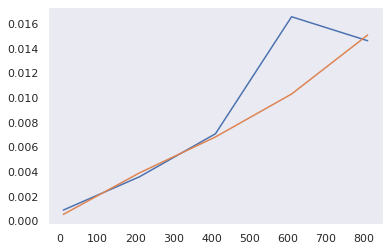

In [162]:
jax_subset = profiles[profiles["Solver"] == "DP5"]
lin_subset = profiles[profiles["Solver"] == "Linear"]
pyplot.plot(jax_subset["Oversample"], jax_subset["Time"])
pyplot.plot(lin_subset["Oversample"], lin_subset["Time"])

Here I need to compare the gradients of the analytic and the linear solution

In [113]:
autodiff = {"Linear": odeint_linear, "DP5": DP5}

In [114]:
results = {
    "module": [],
    "time": [],
    "type": []
}

In [153]:
for solver in autodiff:# Iterating through the namespaces of odeint function 
    function_obj = generate_model(autodiff[solver], 100, production="simple_sinusoid")

    # Running the base function 
    r_profile = profile(function_obj.log_likelihood, parameters)
    results["module"].append(solver)
    results["time"].append(float(r_profile["average"]) * 1000)
    results["type"].append("odeint")

    # Calculating the gradient 
    g_profile = profile(jax.jacobian(function_obj.log_likelihood), parameters)
    results["module"].append(solver)
    results["time"].append(float(g_profile["average"]) * 1000)
    results["type"].append("gradient")

    # Calculating the hessian. This is only done once for computational time
    timer = process_time()
    hessian = jax.jacobian(jax.jacobian(function_obj.log_likelihood))(parameters)
    timer = process_time() - timer
    results["module"].append(solver)
    results["time"].append(float(timer) * 1000)
    results["type"].append("hessian")